<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 MultiplicationScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/4.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.838168
1,0.814640
2,0.801280
3,0.803872
4,0.780264
...,...
38875,0.729952
38876,0.710640
38877,0.736008
38878,0.705272


<AxesSubplot: >

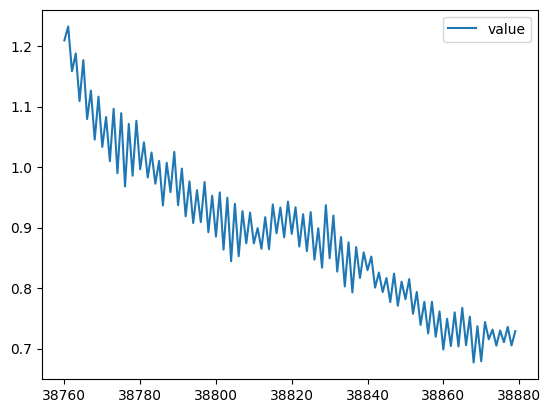

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_585142/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 9.200095426269442 %
smape 7.096140979958034 %
smape 5.979504805080026 %
smape 5.581727604713967 %
smape 5.481954225344442 %
smape 5.227025640660036 %
smape 5.006338551215697 %
smape 4.778954497870734 %
smape 4.7078273607668475 %
smape 4.602451174961109 %
smape 4.507702679825369 %
smape 4.430441162412801 %
smape 4.329767052073315 %
smape 4.2369253106132065 %
smape 4.179416206387574 %
smape 4.138268748875598 %
smape 4.111520510183222 %
smape 4.0333855677156425 %
smape 3.9739305712282658 %
smape 3.9266830825448387 %
smape 3.8699907518661862 %
smape 3.8173898540938285 %
smape 3.8177610567787235 %
smape 3.8005480633732693 %
smape 3.739911879941124 %
smape 3.7121122474754937 %
smape 3.669051973595779 %
smape 3.65696129879277 %
smape 3.6208972546724025 %
smape 3.6326643544635924 %
smape 3.6595951551190247 %
smape 3.60663266966871 %
smape 3.6081444164356817 %
smape 3.582851482359202 %
smape 3.625947955930442 %
smape 3.5863304031435512 %
smape 3.6199052713005337 %
smape 3.5537891650888302

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.7523423385106298 %
SMAPE 1.2744660135940649 %
SMAPE 0.4118043002329159 %
SMAPE 1.0535327509896888 %
SMAPE 1.3862976554446504 %
SMAPE 1.0769128176007143 %
SMAPE 0.13339713131790631 %
SMAPE 0.3310810320544988 %
SMAPE 0.6955104126739116 %
SMAPE 1.1096728253742185 %
SMAPE 1.993392032612974 %
SMAPE 1.9445581484760623 %
SMAPE 1.9605557412496637 %
SMAPE 0.6866185679064074 %
SMAPE 0.31449947770852305 %
SMAPE 0.16016856263013324 %
SMAPE 0.07617642407149106 %
SMAPE 0.3987213081418303 %
SMAPE 0.3414936838671565 %
SMAPE 1.1733209132146385 %
SMAPE 1.0821104816714069 %
SMAPE 1.2016482080407513 %
SMAPE 0.5406727855717008 %
SMAPE 1.0413633843731986 %
SMAPE 0.1703053947594526 %
SMAPE 0.3223039983640774 %
SMAPE 0.3029018110146353 %
SMAPE 0.5076409102766775 %
SMAPE 0.7863553463430435 %
SMAPE 0.22604887911984406 %
SMAPE 0.9486435428825644 %
SMAPE 0.3651092978034285 %
SMAPE 1.949311571313956 %
SMAPE 1.4523596233739227 %
SMAPE 0.2158168120793675 %
SMAPE 1.4467301489221427 %
SMAPE 2.4558459252912144 

SMAPE 0.04649499141316937 %
SMAPE 0.31173407859296276 %
SMAPE 1.1455916902550598 %
SMAPE 0.14638983858458232 %
SMAPE 0.15236370002412514 %
SMAPE 0.3980313396832571 %
SMAPE 0.44552518876298564 %
SMAPE 0.1678243046226271 %
SMAPE 0.4884569402929628 %
SMAPE 0.29809788203419885 %
SMAPE 0.26212474873273095 %
SMAPE 1.128456564514181 %
SMAPE 0.08021885885682423 %
SMAPE 0.16494320584524758 %
SMAPE 0.08693269039247298 %
SMAPE 0.12284014626402495 %
SMAPE 0.2009199178628478 %
SMAPE 0.5399849305358657 %
SMAPE 0.6487094685107877 %
SMAPE 0.5418757035768067 %
SMAPE 1.2033649980785412 %
SMAPE 0.14709432468123396 %
SMAPE 0.15249085241157445 %
SMAPE 0.8529972327228279 %
SMAPE 1.0753541576323187 %
SMAPE 0.3180879143328639 %
SMAPE 0.2424263714965491 %
SMAPE 0.1408564507707979 %
SMAPE 0.5184151174144063 %
SMAPE 0.13044105101744208 %
SMAPE 0.10738008716225524 %
SMAPE 0.7820490488363703 %
SMAPE 0.16796918634418034 %
SMAPE 0.5635859013036679 %
SMAPE 0.05989123523931994 %
SMAPE 0.48945813156205986 %
SMAPE 0.288

SMAPE 0.04458710897779383 %
SMAPE 0.26447700967401033 %
SMAPE 0.7597169603031944 %
SMAPE 0.1391150348961503 %
SMAPE 0.03129781829647982 %
SMAPE 0.21503339599075844 %
SMAPE 0.27486209576159126 %
SMAPE 1.5029284081056176 %
SMAPE 0.6081365633235691 %
SMAPE 0.3700978734286764 %
SMAPE 0.11598453700293022 %
SMAPE 0.08791479753943321 %
SMAPE 0.12093505481880129 %
SMAPE 0.0681842529648975 %
SMAPE 0.022416837002424472 %
SMAPE 0.2209206265447392 %
SMAPE 0.034569481169455685 %
SMAPE 0.04181992705707671 %
SMAPE 0.2426821716681502 %
SMAPE 0.05470286568152005 %
SMAPE 0.06006693547737996 %
SMAPE 0.3356190209289025 %
SMAPE 0.258321948721175 %
SMAPE 0.3207459298228059 %
SMAPE 0.199824572736361 %
SMAPE 1.1989570517052925 %
SMAPE 0.20840555135964678 %
SMAPE 0.06811876750771262 %
SMAPE 0.016162372128746938 %
SMAPE 0.023737480021509327 %
SMAPE 0.04679121164008393 %
SMAPE 0.11163639966491701 %
SMAPE 0.43585598231015865 %
SMAPE 0.4761908009476202 %
SMAPE 0.20605212307117426 %
SMAPE 0.3702529776378469 %
SMAPE

SMAPE 1.6701757137419406 %
SMAPE 0.11872531674634956 %
SMAPE 0.007353116558967088 %
SMAPE 0.02163295789375752 %
SMAPE 0.26018699686753166 %
SMAPE 0.25936238000031153 %
SMAPE 0.365635654653488 %
SMAPE 0.023717573198609898 %
SMAPE 0.13574749044892087 %
SMAPE 0.20679661615741907 %
SMAPE 0.1218199192846896 %
SMAPE 0.05179195029685956 %
SMAPE 0.3083077662017786 %
SMAPE 0.10872249183285021 %
SMAPE 0.0636898520930913 %
SMAPE 0.3641701495000689 %
SMAPE 0.14868534495911945 %
SMAPE 0.3692928767950434 %
SMAPE 1.426841918604623 %
SMAPE 0.987587587949065 %
SMAPE 0.13068339972153353 %
SMAPE 0.058502089219246045 %
SMAPE 0.4285998559598738 %
SMAPE 0.11581615388791988 %
SMAPE 0.027629861034455416 %
SMAPE 0.38844708872966294 %
SMAPE 0.05121455249366136 %
SMAPE 0.5590561840397186 %
SMAPE 0.3330133083209148 %
SMAPE 0.11230212595717148 %
SMAPE 0.10227133267767384 %
SMAPE 0.13883637323897347 %
SMAPE 0.11800981127271369 %
SMAPE 0.7169174590899274 %
SMAPE 0.5702060394795581 %
SMAPE 0.13398536973863884 %
SMAPE

SMAPE 0.09609060774903355 %
SMAPE 0.07828537587874962 %
SMAPE 0.046433232972049154 %
SMAPE 0.01592312492795145 %
SMAPE 0.3360581219828589 %
SMAPE 0.10325803135322076 %
SMAPE 0.15637046327583448 %
SMAPE 0.04939282203122275 %
SMAPE 0.18752276249665556 %
SMAPE 1.549507299441757 %
SMAPE 0.15444217557728734 %
SMAPE 0.1675372317295114 %
SMAPE 0.042026479077577505 %
SMAPE 0.44758153175416737 %
SMAPE 0.6457894957052304 %
SMAPE 0.20868662627617596 %
SMAPE 0.13366385416702542 %
SMAPE 0.06847771459069918 %
SMAPE 0.11999524624025071 %
SMAPE 0.0950112742877991 %
SMAPE 0.1683192318600959 %
SMAPE 0.23253097435923564 %
SMAPE 0.20932427203297269 %
SMAPE 0.08655045050932131 %
SMAPE 0.025500798155917433 %
SMAPE 0.3026526303656283 %
SMAPE 0.2715815472547547 %
SMAPE 0.09188015532498639 %
SMAPE 0.04967419261794248 %
SMAPE 0.44354002118961944 %
SMAPE 0.8926489656632839 %
SMAPE 0.8487512195742966 %
SMAPE 0.10437926918370975 %
SMAPE 0.17495716166854436 %
SMAPE 0.05525633149898113 %
SMAPE 0.1414120787885622 %
S

SMAPE 0.2560157511361467 %
SMAPE 0.12660141495962307 %
SMAPE 0.2694886130741452 %
SMAPE 0.26611482649423124 %
SMAPE 0.2220908324488846 %
SMAPE 0.7644263267447968 %
SMAPE 0.7276500305888476 %
SMAPE 0.0750618183901679 %
SMAPE 0.6661921266386344 %
SMAPE 0.5561000488678474 %
SMAPE 0.10678437787464647 %
SMAPE 0.13264046564836462 %
SMAPE 18.43819302477641 %
SMAPE 23.061352141201496 %
SMAPE 21.07501819776371 %
SMAPE 5.684104706955395 %
SMAPE 1.9391774991872808 %
SMAPE 2.543564498453634 %
SMAPE 0.09319255493937817 %
SMAPE 0.5019226037957196 %
SMAPE 0.6808445133642635 %
SMAPE 0.30315798300580354 %
SMAPE 0.9026335826797549 %
SMAPE 0.7969692057567954 %
SMAPE 0.5633607188901806 %
SMAPE 0.23951823561355923 %
SMAPE 0.11037708267167545 %
SMAPE 0.6658293792861514 %
SMAPE 0.5670044090202282 %
SMAPE 0.6310095241269664 %
SMAPE 0.21532750934329672 %
SMAPE 0.08834590626793215 %
SMAPE 1.368172755544947 %
SMAPE 0.9034240839719132 %
SMAPE 0.3418568426232014 %
SMAPE 0.03300864453615304 %
SMAPE 0.23053186572224

SMAPE 0.0256906105530561 %
SMAPE 0.1597332624601222 %
SMAPE 0.4053000162616627 %
SMAPE 0.42026033019646997 %
SMAPE 0.1511561666684429 %
SMAPE 0.6234652738550039 %
SMAPE 0.08844329591869382 %
SMAPE 0.3927393568966408 %
SMAPE 0.03985840194582124 %
SMAPE 0.07881949317845738 %
SMAPE 0.18401595636714774 %
SMAPE 0.7687724266588702 %
SMAPE 0.35249521646255744 %
SMAPE 0.8559809248872625 %
SMAPE 0.31235117190408346 %
SMAPE 1.3778476197371958 %
SMAPE 0.21994606139196549 %
SMAPE 0.11519798814879324 %
SMAPE 0.26195325891785615 %
SMAPE 0.6972230834708171 %
SMAPE 0.35495700898309224 %
SMAPE 0.1942414756464359 %
SMAPE 0.10069664791200238 %
SMAPE 0.5611630085552406 %
SMAPE 0.13552816755031927 %
SMAPE 0.4193947484634464 %
SMAPE 0.02440155551630596 %
SMAPE 0.14281837909584283 %
SMAPE 0.07434447478954098 %
SMAPE 0.44152804400118845 %
SMAPE 0.18474141562865043 %
SMAPE 0.43105338282475714 %
SMAPE 0.079806801853465 %
SMAPE 0.18420414126694595 %
SMAPE 0.14462898952660908 %
SMAPE 0.20433803236380754 %
SMAPE 0

SMAPE 0.16996977157714355 %
SMAPE 0.031229480755342823 %
SMAPE 0.30558659469073746 %
SMAPE 0.11686395344952416 %
SMAPE 0.033897172704200784 %
SMAPE 0.1030196312018461 %
SMAPE 0.7253871688185427 %
SMAPE 0.033724328206346854 %
SMAPE 0.4325848000530641 %
SMAPE 0.24124631829090504 %
SMAPE 0.12875281796580396 %
SMAPE 0.0324273945642517 %
SMAPE 0.1870967751419812 %
SMAPE 0.4780260105990237 %
SMAPE 0.05341652122524465 %
SMAPE 0.08837287762844426 %
SMAPE 0.06371927643795061 %
SMAPE 0.2442600248770077 %
SMAPE 1.028524000721518 %
SMAPE 0.14121556604914076 %
SMAPE 0.6706924224067734 %
SMAPE 0.07442564252710326 %
SMAPE 0.11037055610813695 %
SMAPE 0.0601030516645551 %
SMAPE 0.14317708204333712 %
SMAPE 0.28438747909086715 %
SMAPE 0.8004975510259557 %
SMAPE 0.8853307773487131 %
SMAPE 0.026515042289247504 %
SMAPE 0.09486980717338156 %
SMAPE 0.13699304219198893 %
SMAPE 0.39979191501515743 %
SMAPE 0.08914050918338035 %
SMAPE 0.19805859153711938 %
SMAPE 0.24102587380230037 %
SMAPE 0.1710792504973142 %
SM

SMAPE 0.0889240143525285 %
SMAPE 0.14983857995594008 %
SMAPE 0.01286894645272696 %
SMAPE 0.012182390963062062 %
SMAPE 0.07341770653511048 %
SMAPE 0.10758443468796486 %
SMAPE 0.36832561125356733 %
SMAPE 0.08824547876440647 %
SMAPE 0.1086534677220925 %
SMAPE 0.046825300877429754 %
SMAPE 0.09572225586140348 %
SMAPE 0.5058728059930218 %
SMAPE 0.7094485308798539 %
SMAPE 0.3080971005180544 %
SMAPE 0.016951787522884842 %
SMAPE 0.05044994990885244 %
SMAPE 0.02115815519005082 %
SMAPE 0.12384686606952755 %
SMAPE 0.08203632458207721 %
SMAPE 0.15450286141594916 %
SMAPE 0.06682034551897686 %
SMAPE 0.059665310814807526 %
SMAPE 0.2188137377218595 %
SMAPE 0.07881232816998818 %
SMAPE 0.011294793243905588 %
SMAPE 0.06187709058360724 %
SMAPE 0.21616893214945776 %
SMAPE 0.10740133534511641 %
SMAPE 0.28733586623820884 %
SMAPE 0.7389588602554795 %
SMAPE 0.031420401103872564 %
SMAPE 0.2305435234962374 %
SMAPE 2.3405460759386187 %
SMAPE 0.8833366398430371 %
SMAPE 0.03841619473951141 %
SMAPE 0.1276348629266976

SMAPE 0.2939918560393835 %
SMAPE 0.1039268549902772 %
SMAPE 0.02697999094016268 %
SMAPE 0.25672433030013053 %
SMAPE 0.03970114752246445 %
SMAPE 0.4124479101584484 %
SMAPE 0.09338099475462514 %
SMAPE 0.28997811830049613 %
SMAPE 0.029693352076719748 %
SMAPE 0.10024061052649813 %
SMAPE 0.7182824378389796 %
SMAPE 0.03322183274121926 %
SMAPE 0.5563673787364678 %
SMAPE 0.12091795556034413 %
SMAPE 0.0367371934332823 %
SMAPE 2.0522087513872975 %
SMAPE 0.075931710095972 %
SMAPE 0.142440353101847 %
SMAPE 0.1800977049233552 %
SMAPE 0.43253584692502045 %
SMAPE 0.12748004767490784 %
SMAPE 1.6457904306953424 %
SMAPE 0.025965858638301142 %
SMAPE 0.6420771151606459 %
SMAPE 0.12484046771896828 %
SMAPE 0.020076819106179755 %
SMAPE 0.08372406689630907 %
SMAPE 0.030836147265290492 %
SMAPE 0.06411675817980722 %
SMAPE 0.07916161870571159 %
SMAPE 0.14968492347179563 %
SMAPE 0.05919354652527886 %
SMAPE 0.28154465693205566 %
SMAPE 0.5859270511282375 %
SMAPE 0.04204203687606878 %
SMAPE 0.02920319104975988 %
SMA

SMAPE 0.37526500910280447 %
SMAPE 0.6933379425281601 %
SMAPE 0.8793812225394788 %
SMAPE 0.6729866930877506 %
SMAPE 1.4171143157338975 %
SMAPE 0.5907502884401765 %
SMAPE 1.0122110512311338 %
SMAPE 0.9599146923974331 %
SMAPE 0.11526834630240046 %
SMAPE 0.344490914357948 %
SMAPE 0.18671648712916067 %
SMAPE 0.7534963736216014 %
SMAPE 0.15702654182132392 %
SMAPE 0.14265912929045044 %
SMAPE 0.09027312602484017 %
SMAPE 0.9823339149506863 %
SMAPE 0.1327491293195635 %
SMAPE 0.9435222520114621 %
SMAPE 0.41629481178688366 %
SMAPE 0.5463695603862107 %
SMAPE 0.3080299233461119 %
SMAPE 0.5336156113662582 %
SMAPE 1.0474654744084546 %
SMAPE 0.8688063199851968 %
SMAPE 0.11002641800700985 %
SMAPE 0.5233409709494481 %
SMAPE 0.24327708407054163 %
SMAPE 0.7800480209766647 %
SMAPE 0.23111685004892024 %
SMAPE 0.5342487910584168 %
SMAPE 0.458185334893642 %
SMAPE 0.4761986234075266 %
SMAPE 0.2566822672415583 %
SMAPE 0.2635121786443051 %
SMAPE 0.7750147742008267 %
SMAPE 0.5445918676723522 %
SMAPE 0.864485840099

SMAPE 0.03232393988309923 %
SMAPE 0.07506729575243298 %
SMAPE 0.015040842913549568 %
SMAPE 0.36333884843190845 %
SMAPE 2.0383003073075088 %
SMAPE 0.02465794181586034 %
SMAPE 0.10586112069165665 %
SMAPE 0.6623428263701499 %
SMAPE 0.18175379324748064 %
SMAPE 0.1246343857969805 %
SMAPE 0.5048788928552312 %
SMAPE 0.43907263068823 %
SMAPE 0.19290218218452537 %
SMAPE 0.031148393896614838 %
SMAPE 0.47257389437891106 %
SMAPE 0.18367663939216072 %
SMAPE 0.7517068242327696 %
SMAPE 0.2052246942666898 %
SMAPE 0.32449748544786416 %
SMAPE 0.2459790636935395 %
SMAPE 0.31125542389486327 %
SMAPE 0.023765050664223963 %
SMAPE 0.4837973542282441 %
SMAPE 0.6226577349752915 %
SMAPE 4.541898467709871 %
SMAPE 0.28917589101070007 %
SMAPE 0.3149467131097481 %
SMAPE 0.1367597806185188 %
SMAPE 0.7703474929317053 %
SMAPE 0.26965045193094284 %
SMAPE 0.337650965136163 %
SMAPE 0.18086802064703988 %
SMAPE 0.5429072459489817 %
SMAPE 1.001113951100706 %
SMAPE 0.6781548646922602 %
SMAPE 0.017928918575307762 %
SMAPE 0.511

SMAPE 0.18638847399051883 %
SMAPE 0.0829181401495589 %
SMAPE 0.025731223924438492 %
SMAPE 0.008213753943039137 %
SMAPE 0.13498678289909094 %
SMAPE 0.23136434354296395 %
SMAPE 0.4916437327831318 %
SMAPE 0.30632670690010855 %
SMAPE 0.48110682204060135 %
SMAPE 1.2593031953147147 %
SMAPE 0.11963731924242893 %
SMAPE 1.3573080856585875 %
SMAPE 0.14218804248503147 %
SMAPE 0.25615841680428275 %
SMAPE 0.6227480051020393 %
SMAPE 1.2581668483799149 %
SMAPE 1.0850816774654959 %
SMAPE 0.25926157182857423 %
SMAPE 0.08518961518643664 %
SMAPE 0.3764839158684481 %
SMAPE 0.29565495801227826 %
SMAPE 0.2010313246027522 %
SMAPE 0.27141620231259367 %
SMAPE 0.11818753870545606 %
SMAPE 0.015479387976938597 %
SMAPE 0.043766581925353876 %
SMAPE 0.11383195467760743 %
SMAPE 0.969875981536461 %
SMAPE 0.03712753024581161 %
SMAPE 1.1025183872661728 %
SMAPE 0.048305350820839976 %
SMAPE 0.08893982202607731 %
SMAPE 0.02897792723638304 %
SMAPE 0.06877360238047459 %
SMAPE 0.3222445007322676 %
SMAPE 1.3739395819593483 %
S

SMAPE 0.11246168951856816 %
SMAPE 0.03709199769480165 %
SMAPE 0.6854237567149539 %
SMAPE 0.16566970212306842 %
SMAPE 0.15844070607363392 %
SMAPE 0.012072972444769903 %
SMAPE 0.025724605084448626 %
SMAPE 2.510686034045648 %
SMAPE 1.0516847585786309 %
SMAPE 0.0675553126552586 %
SMAPE 0.0960347909773418 %
SMAPE 0.06704916353737644 %
SMAPE 0.04375457502919744 %
SMAPE 0.6826951438647484 %
SMAPE 0.308216053108481 %
SMAPE 0.023888188673083732 %
SMAPE 0.10423634299456808 %
SMAPE 0.5374081687564285 %
SMAPE 0.11589315671881195 %
SMAPE 0.04678718845104868 %
SMAPE 0.1158634332757913 %
SMAPE 0.27102627473550456 %
SMAPE 0.18990109840112268 %
SMAPE 0.027482558581425565 %
SMAPE 0.9878583295067073 %
SMAPE 0.3872183299781682 %
SMAPE 0.11510566150695922 %
SMAPE 2.5448072804047115 %
SMAPE 0.17904561996374468 %
SMAPE 0.14537446865824677 %
SMAPE 0.5304721284683183 %
SMAPE 0.059892655415751506 %
SMAPE 0.243802428003562 %
SMAPE 0.041362352028158966 %
SMAPE 0.2369604244149741 %
SMAPE 0.3999025047032773 %
SMAPE

SMAPE 0.12493976801999906 %
SMAPE 0.03952234125063114 %
SMAPE 0.5789488236387115 %
SMAPE 0.5296929385253861 %
SMAPE 0.7305502429426269 %
SMAPE 0.38738928776365356 %
SMAPE 0.12941474041863898 %
SMAPE 1.5881369506960255 %
SMAPE 0.07619532398166484 %
SMAPE 0.35253324084533233 %
SMAPE 0.3302781739589591 %
SMAPE 0.7280629717752163 %
SMAPE 1.0207715191681928 %
SMAPE 0.0022327590249915374 %
SMAPE 0.2917552488124784 %
SMAPE 0.6232715329279017 %
SMAPE 0.22900415616072678 %
SMAPE 0.3078736827132502 %
SMAPE 0.01628188584692225 %
SMAPE 0.06494666196249455 %
SMAPE 0.3216636413735614 %
SMAPE 0.43211225843015194 %
SMAPE 0.08118752653012962 %
SMAPE 1.1064562654310066 %
SMAPE 0.07596671501615049 %
SMAPE 0.6784507444735937 %
SMAPE 0.25957499588253086 %
SMAPE 0.11814788707579281 %
SMAPE 0.03813709131736687 %
SMAPE 0.037258809577082275 %
SMAPE 0.06694396838611283 %
SMAPE 0.4192187772343914 %
SMAPE 1.4011797735747678 %
SMAPE 3.6687511829950377 %
SMAPE 0.6517557746028615 %
SMAPE 0.10746532804023447 %
SMAPE 

SMAPE 0.10340852706707437 %
SMAPE 0.4221873641108686 %
SMAPE 0.051203543032329435 %
SMAPE 1.287772362740725 %
SMAPE 0.13075464972826012 %
SMAPE 0.23994405543453468 %
SMAPE 1.2778239012679933 %
SMAPE 0.1875190148902135 %
SMAPE 0.40924866067689436 %
SMAPE 0.9427196500473656 %
SMAPE 0.19791595286096705 %
SMAPE 0.11494647865947627 %
SMAPE 0.8527667937960359 %
SMAPE 0.21463180654973257 %
SMAPE 0.05675866145625719 %
SMAPE 0.340023423636012 %
SMAPE 0.48665522408600737 %
SMAPE 1.4099162011079898 %
SMAPE 0.21353800736596895 %
SMAPE 1.5107882771790173 %
SMAPE 0.3197352515385319 %
SMAPE 0.14221933591733205 %
SMAPE 1.6047813138820854 %
SMAPE 0.3058604457137335 %
SMAPE 0.126444005522103 %
SMAPE 0.015500055970875339 %
SMAPE 4.3378627284109825 %
SMAPE 1.9445899569182075 %
SMAPE 6.512344380509603 %
SMAPE 0.13374766245647152 %
SMAPE 0.21168494686571648 %
SMAPE 2.378322329648654 %
SMAPE 0.5340468767244602 %
SMAPE 2.163038714992581 %
SMAPE 2.043737695931185 %
SMAPE 0.5505981523347145 %
SMAPE 0.2825079849

SMAPE 0.26487224761649486 %
SMAPE 0.27475817494087096 %
SMAPE 0.023436819838025258 %
SMAPE 0.5435150494158734 %
SMAPE 0.6237533247335705 %
SMAPE 0.03126822682634156 %
SMAPE 0.04647901748148797 %
SMAPE 0.20108395258330347 %
SMAPE 0.10240628411725085 %
SMAPE 0.02183402011473845 %
SMAPE 0.7727195713728179 %
SMAPE 0.3414046153993695 %
SMAPE 0.053517993463174214 %
SMAPE 0.06742981793320268 %
SMAPE 0.1873247670323508 %
SMAPE 0.17300382892432253 %
SMAPE 2.026865124928918 %
SMAPE 0.26350634216078106 %
SMAPE 0.39784990600412584 %
SMAPE 0.3063997615961398 %
SMAPE 0.14242945682349273 %
SMAPE 0.07433344092247296 %
SMAPE 0.218007491365654 %
SMAPE 0.10079344997564021 %
SMAPE 0.07674847993075673 %
SMAPE 0.4685798833129411 %
SMAPE 0.05681235442057186 %
SMAPE 0.31345793715695436 %
SMAPE 0.334522768494935 %
SMAPE 0.45393711692770466 %
SMAPE 0.315301790274475 %
SMAPE 0.43044236769628696 %
SMAPE 0.6286635892356571 %
SMAPE 0.10062761021163169 %
SMAPE 0.7168730981454701 %
SMAPE 0.11977510784959122 %
SMAPE 0

SMAPE 0.029289210565707435 %
SMAPE 0.1827436015356625 %
SMAPE 0.29602295198020556 %
SMAPE 1.6185679391055598 %
SMAPE 0.9610815481282771 %
SMAPE 0.18721161769690298 %
SMAPE 0.2578216101101134 %
SMAPE 0.29449522527123406 %
SMAPE 0.5118073392222868 %
SMAPE 0.054730785162888644 %
SMAPE 0.12053004705813919 %
SMAPE 0.24154100447458404 %
SMAPE 0.30957548780224897 %
SMAPE 0.009503280310923401 %
SMAPE 0.08096016351009894 %
SMAPE 0.18712427686477895 %
SMAPE 0.5471965059921331 %
SMAPE 0.032125255943867614 %
SMAPE 0.0058614107209962185 %
SMAPE 0.09567699575234201 %
SMAPE 0.20245215959869256 %
SMAPE 0.22744786718067192 %
SMAPE 0.052357270752395386 %
SMAPE 3.599311931000557 %
SMAPE 0.8307412882641075 %
SMAPE 0.4515988886971627 %
SMAPE 0.04747246628062385 %
SMAPE 0.30595087179813163 %
SMAPE 0.23562054210765382 %
SMAPE 0.19547829412567808 %
SMAPE 0.6994121325801643 %
SMAPE 0.009686635412379019 %
SMAPE 0.20103277233283734 %
SMAPE 0.2971501682432063 %
SMAPE 0.08926864440195459 %
SMAPE 0.2191843358942833

SMAPE 0.09781084734922273 %
SMAPE 0.11465700316625771 %
SMAPE 0.045206052308344624 %
SMAPE 0.4750494532011089 %
SMAPE 1.374838514784642 %
SMAPE 0.13462646243954168 %
SMAPE 0.7217023716675612 %
SMAPE 0.45612038829750645 %
SMAPE 0.052878086971986704 %
SMAPE 0.2511800150747945 %
SMAPE 0.05874075699648528 %
SMAPE 0.5367566929153327 %
SMAPE 0.3331292914044752 %
SMAPE 1.738479163228476 %
SMAPE 1.8014560184528818 %
SMAPE 0.6474293661995034 %
SMAPE 0.20023665622466072 %
SMAPE 0.33778880852332804 %
SMAPE 0.32275916936035287 %
SMAPE 0.011341849944699334 %
SMAPE 0.12166815821854016 %
SMAPE 0.23462666143313984 %
SMAPE 0.863970273443556 %
SMAPE 0.325503293550355 %
SMAPE 0.004724438562789146 %
SMAPE 0.027739119122543343 %
SMAPE 0.024079441551975833 %
SMAPE 0.2915923988405211 %
SMAPE 0.06931643628513484 %
SMAPE 0.48089034147369597 %
SMAPE 0.0656075536311107 %
SMAPE 0.17953321605659767 %
SMAPE 0.2467665798857865 %
SMAPE 0.13883168181746441 %
SMAPE 0.021631050968522914 %
SMAPE 0.45909525023625974 %
SMA

SMAPE 0.09708701810495768 %
SMAPE 1.540413710699795 %
SMAPE 3.8124923486320768 %
SMAPE 0.2724315646389641 %
SMAPE 0.1587376580309865 %
SMAPE 0.05309009390452957 %
SMAPE 0.48169666948166423 %
SMAPE 0.41232036906330904 %
SMAPE 0.03842982582671084 %
SMAPE 0.19797257375967092 %
SMAPE 1.1598732430034033 %
SMAPE 0.05742916295412215 %
SMAPE 0.0074920825507192035 %
SMAPE 0.2990671017192881 %
SMAPE 0.3523392162487653 %
SMAPE 0.30148015943268547 %
SMAPE 2.0420613359001436 %
SMAPE 0.05299565124767014 %
SMAPE 0.18689936996736378 %
SMAPE 0.05816840354782472 %
SMAPE 0.10300234090800586 %
SMAPE 0.24147069883326822 %
SMAPE 0.12134627279738197 %
SMAPE 2.737428227555938 %
SMAPE 0.14525132622804904 %
SMAPE 1.0395376326923724 %
SMAPE 0.14381642789930993 %
SMAPE 0.3194804422849984 %
SMAPE 0.37364221080497373 %
SMAPE 0.9003361508493981 %
SMAPE 0.09398717518388366 %
SMAPE 0.2861532141814678 %
SMAPE 0.9287563435336779 %
SMAPE 0.05781635094626836 %
SMAPE 0.18170533960756075 %
SMAPE 0.05978738145535089 %
SMAPE 

SMAPE 1.1671427857927483 %
SMAPE 0.3864747404695663 %
SMAPE 0.4673958688076709 %
SMAPE 0.3226429760387646 %
SMAPE 0.1545271934592165 %
SMAPE 0.5382530859660619 %
SMAPE 0.28896814175755026 %
SMAPE 0.2021853051137441 %
SMAPE 1.236799200232781 %
SMAPE 0.2239458966100756 %
SMAPE 0.8501701738575775 %
SMAPE 0.7807506513026965 %
SMAPE 1.0155571016682643 %
SMAPE 0.3841018918728878 %
SMAPE 0.4760883282260693 %
SMAPE 0.20960687168735606 %
SMAPE 0.1358935015505267 %
SMAPE 0.4249551339225946 %
SMAPE 0.02681651231250726 %
SMAPE 0.9043331329557986 %
SMAPE 0.4760824207846781 %
SMAPE 0.21309544209725573 %
SMAPE 0.2984861945224111 %
SMAPE 0.15614764866205633 %
SMAPE 0.242116239126517 %
SMAPE 0.10895380054876114 %
SMAPE 0.7988169051219528 %
SMAPE 0.21814307477552572 %
SMAPE 0.5363289303340935 %
SMAPE 0.19113543340073136 %
SMAPE 0.33108659376713945 %
SMAPE 0.5948196589142754 %
SMAPE 0.9503769928069233 %
SMAPE 0.8620323039085633 %
SMAPE 0.10727081388267833 %
SMAPE 0.07140677075631174 %
SMAPE 0.15098882763

SMAPE 0.3542956064259215 %
SMAPE 1.6797068357245735 %
SMAPE 0.9169220689868781 %
SMAPE 1.4390448097283297 %
SMAPE 0.0778164858911623 %
SMAPE 0.4079150554343869 %
SMAPE 0.3483819886064339 %
SMAPE 0.29388749076315435 %
SMAPE 0.3813276435334956 %
SMAPE 0.6738256924372763 %
SMAPE 0.1846865323406064 %
SMAPE 0.04854524038432828 %
SMAPE 0.16913668338685284 %
SMAPE 0.05244747959179108 %
SMAPE 0.5506281854750341 %
SMAPE 0.018198765952732288 %
SMAPE 0.007069344692808954 %
SMAPE 0.048424150085338624 %
SMAPE 0.40058295360483953 %
SMAPE 0.18812728231068832 %
SMAPE 0.19633550335947803 %
SMAPE 0.04732802403395908 %
SMAPE 0.0351071736627091 %
SMAPE 0.052798580204125756 %
SMAPE 0.07295845034599324 %
SMAPE 0.5092413384118117 %
SMAPE 0.5689698852020229 %
SMAPE 0.9663670185473165 %
SMAPE 0.06775824696899235 %
SMAPE 0.5164908782213615 %
SMAPE 0.21444293912509238 %
SMAPE 0.2703981384902363 %
SMAPE 0.15616038940152066 %
SMAPE 0.5976695601470965 %
SMAPE 0.25784701726661297 %
SMAPE 0.2140340488443826 %
SMAPE 0

SMAPE 0.021796237094804383 %
SMAPE 0.6377547636147938 %
SMAPE 0.05842933919029746 %
SMAPE 0.09265568989576423 %
SMAPE 0.4060066760580412 %
SMAPE 0.4066680569412711 %
SMAPE 0.06322577464493406 %
SMAPE 0.35737231901021005 %
SMAPE 0.15926825569022185 %
SMAPE 0.3634780411627503 %
SMAPE 0.035850252464243226 %
SMAPE 0.04765696294117561 %
SMAPE 0.15304030253375345 %
SMAPE 0.3073667011235557 %
SMAPE 0.43225717516456547 %
SMAPE 0.06704638598989732 %
SMAPE 0.009067720394085654 %
SMAPE 0.052133135889704356 %
SMAPE 0.19392418137954337 %
SMAPE 0.29102937567444087 %
SMAPE 0.09406628925489713 %
SMAPE 0.03929441904827513 %
SMAPE 0.06282820342858031 %
SMAPE 0.16815765193427978 %
SMAPE 0.05817852565314751 %
SMAPE 0.12390559846289761 %
SMAPE 0.013998138514693894 %
SMAPE 0.09761080156874868 %
SMAPE 0.5092053769458289 %
SMAPE 0.07676163774362976 %
SMAPE 0.343305750665877 %
SMAPE 1.1749209854569926 %
SMAPE 0.44591955178839265 %
SMAPE 0.8962242324423642 %
SMAPE 0.872788854188002 %
SMAPE 1.2293454002647195 %


SMAPE 0.10942029421664755 %
SMAPE 0.21892138296743724 %
SMAPE 0.027336260144977587 %
SMAPE 0.1651521071639337 %
SMAPE 0.05148013966424969 %
SMAPE 0.1928813066585917 %
SMAPE 0.47918833867151994 %
SMAPE 0.2809325061832624 %
SMAPE 0.05803196776503227 %
SMAPE 0.06370592793206242 %
SMAPE 0.12350936285611168 %
SMAPE 0.9857281997045106 %
SMAPE 0.016777944866589678 %
SMAPE 0.4138166858438126 %
SMAPE 0.38995221180721273 %
SMAPE 0.5631916343606918 %
SMAPE 0.0063622097733286856 %
SMAPE 0.023282854876185866 %
SMAPE 0.3479292466718107 %
SMAPE 0.020293208153873366 %
SMAPE 0.05300407162553711 %
SMAPE 1.1710135945904767 %
SMAPE 0.06003059692102397 %
SMAPE 1.5882845493033526 %
SMAPE 0.1104852464227406 %
SMAPE 0.3331665068935763 %
SMAPE 0.18605662133313672 %
SMAPE 0.7004460109587853 %
SMAPE 1.1896215803517407 %
SMAPE 0.05424491924929953 %
SMAPE 0.1180279557038375 %
SMAPE 0.06931795560558385 %
SMAPE 0.011151252972098291 %
SMAPE 0.40521013223042246 %
SMAPE 0.027984520621998854 %
SMAPE 0.09348247339897853 

SMAPE 0.029853491142944222 %
SMAPE 0.010749784246499416 %
SMAPE 0.5214845350669748 %
SMAPE 0.06682468311919365 %
SMAPE 1.8131096550860093 %
SMAPE 1.1000343709429217 %
SMAPE 0.0652400681653944 %
SMAPE 1.063722645460075 %
SMAPE 0.12253341987286603 %
SMAPE 0.3164052266511135 %
SMAPE 0.11217949942192718 %
SMAPE 0.24347915584803562 %
SMAPE 0.6182342405691088 %
SMAPE 0.9763429271843052 %
SMAPE 0.05742512294546031 %
SMAPE 0.32646539159395616 %
SMAPE 0.31564833253082725 %
SMAPE 0.1516613937171769 %
SMAPE 0.8293016353181883 %
SMAPE 1.3124407635659736 %
SMAPE 0.28076353554729394 %
SMAPE 0.023561504932615662 %
SMAPE 0.020929359687215765 %
SMAPE 1.6023579721677381 %
SMAPE 0.2644487448687869 %
SMAPE 0.42787705572345663 %
SMAPE 0.07193513247511873 %
SMAPE 0.12631762102500943 %
SMAPE 0.5186308652646403 %
SMAPE 0.0549450929138402 %
SMAPE 0.4724123924877404 %
SMAPE 0.9815866385215486 %
SMAPE 0.07547715116049858 %
SMAPE 0.021535996605962282 %
SMAPE 0.08941333925122308 %
SMAPE 1.2493655135262287 %
SMAPE 

SMAPE 0.059521005065676036 %
SMAPE 0.2278436728192901 %
SMAPE 0.05624298137809091 %
SMAPE 0.6095882142798246 %
SMAPE 0.01761221629578813 %
SMAPE 0.7533385095448466 %
SMAPE 0.24929179501486945 %
SMAPE 0.04298081769871942 %
SMAPE 0.768657018099475 %
SMAPE 0.617319731558382 %
SMAPE 0.9891667292349667 %
SMAPE 0.2017643421199864 %
SMAPE 0.03024241570540198 %
SMAPE 0.0833175210468653 %
SMAPE 0.13991077336925173 %
SMAPE 0.13323939478868851 %
SMAPE 0.29965147197003716 %
SMAPE 1.3364470371202515 %
SMAPE 0.0209209438767175 %
SMAPE 0.21897312067085295 %
SMAPE 0.5581628142099362 %
SMAPE 0.08436679260830715 %
SMAPE 0.09244238891506029 %
SMAPE 0.1970421069991062 %
SMAPE 0.08458081019512065 %
SMAPE 0.4926736010975219 %
SMAPE 1.2509497825121798 %
SMAPE 1.3210112021927216 %
SMAPE 0.18829378225708382 %
SMAPE 2.8284058955905493 %
SMAPE 0.33264762846965823 %
SMAPE 0.9603285942248476 %
SMAPE 0.01921207487677634 %
SMAPE 0.22464430085847195 %
SMAPE 0.3918316927029082 %
SMAPE 0.27734913393362604 %
SMAPE 0.251

SMAPE 0.010133101451970106 %
SMAPE 0.09508559217607626 %
SMAPE 0.01638509039582914 %
SMAPE 0.02609922428516143 %
SMAPE 0.013585193906465065 %
SMAPE 0.036977360280900484 %
SMAPE 0.03571345386671965 %
SMAPE 0.07956108983950116 %
SMAPE 0.006165183098978844 %
SMAPE 0.7143776361881464 %
SMAPE 0.7824135455593931 %
SMAPE 0.2595349749235538 %
SMAPE 0.26007162936093664 %
SMAPE 0.5090048237361771 %
SMAPE 0.9611878606665413 %
SMAPE 0.028609345717526935 %
SMAPE 0.03319878763298334 %
SMAPE 0.04102298210227673 %
SMAPE 0.030697564247361697 %
SMAPE 0.14273317181209677 %
SMAPE 0.32511162999469434 %
SMAPE 0.2995920951611879 %
SMAPE 0.5229370252545777 %
SMAPE 0.0197500559661421 %
SMAPE 0.2642404797202289 %
SMAPE 0.02686142865832153 %
SMAPE 0.05488772911826346 %
SMAPE 0.5042708956352726 %
SMAPE 0.16141817062793962 %
SMAPE 0.17210724865299198 %
SMAPE 0.7031682009637734 %
SMAPE 1.0858633663556247 %
SMAPE 0.018580001201996765 %
SMAPE 0.056372972446297354 %
SMAPE 0.06119191584502914 %
SMAPE 0.0272463673595666

SMAPE 0.20456176973664242 %
SMAPE 0.008664165961903336 %
SMAPE 0.05910638343691942 %
SMAPE 0.11854758575782398 %
SMAPE 0.0448594181564701 %
SMAPE 0.054686825424141716 %
SMAPE 1.428850436214816 %
SMAPE 0.4302949246307435 %
SMAPE 0.10337199019863876 %
SMAPE 0.044827389838928866 %
SMAPE 0.028807486997266096 %
SMAPE 0.042952129087012736 %
SMAPE 0.23720744379301092 %
SMAPE 0.08801945579762105 %
SMAPE 0.12685526345353537 %
SMAPE 0.10084714157187591 %
SMAPE 0.5349726068410519 %
SMAPE 0.10258325859251727 %
SMAPE 0.26528287587287025 %
SMAPE 0.021563651914050297 %
SMAPE 0.0947575025502374 %
SMAPE 0.6561379612649034 %
SMAPE 0.1660851988797276 %
SMAPE 0.20796295451236801 %
SMAPE 0.4927232176290772 %
SMAPE 0.05979893843351647 %
SMAPE 0.28961033209566267 %
SMAPE 0.06792494195605059 %
SMAPE 0.045948538564971386 %
SMAPE 0.19383614212074463 %
SMAPE 0.8859534414236805 %
SMAPE 0.10820312756322892 %
SMAPE 0.2979517913440759 %
SMAPE 0.3888412161668384 %
SMAPE 0.10717565918048422 %
SMAPE 0.5335085675060327 

SMAPE 0.47393827461564797 %
SMAPE 0.7726056964202144 %
SMAPE 3.391726991605538 %
SMAPE 0.5924052631980885 %
SMAPE 0.5381050670839613 %
SMAPE 0.20623279680512496 %
SMAPE 0.33380188959199586 %
SMAPE 0.06672465244173509 %
SMAPE 0.14596858787263045 %
SMAPE 0.24997884353933844 %
SMAPE 0.09097658476184733 %
SMAPE 1.0724326630042924 %
SMAPE 0.6700697794394728 %
SMAPE 0.8924720262148184 %
SMAPE 1.876155503814516 %
SMAPE 2.012737870952151 %
SMAPE 0.048722531895691645 %
SMAPE 0.3214368718727201 %
SMAPE 0.2213626833081435 %
SMAPE 0.09212878379867107 %
SMAPE 0.040677650631096185 %
SMAPE 0.2334958187727807 %
SMAPE 0.04200289882578545 %
SMAPE 0.9001480264660131 %
SMAPE 1.052933939761715 %
SMAPE 0.8612446447791626 %
SMAPE 0.056670811782112196 %
SMAPE 0.939596081891068 %
SMAPE 0.2366316236759758 %
SMAPE 0.020939046924240756 %
SMAPE 0.8645878780062048 %
SMAPE 0.012765761741206916 %
SMAPE 0.05827454982818381 %
SMAPE 0.20983549216748543 %
SMAPE 0.06645191900888392 %
SMAPE 0.2862649018297816 %
SMAPE 0.198

SMAPE 0.016920447927873283 %
SMAPE 0.024360103227650143 %
SMAPE 0.20946186599576322 %
SMAPE 0.7170337695897615 %
SMAPE 0.10113922679875031 %
SMAPE 0.2193181951720362 %
SMAPE 0.4238060923999001 %
SMAPE 0.04153960559233383 %
SMAPE 0.14818144707896863 %
SMAPE 0.0319513817231325 %
SMAPE 0.8364109971553261 %
SMAPE 0.43189265817284195 %
SMAPE 0.4435876326469952 %
SMAPE 0.1220729453406193 %
SMAPE 0.3850574562275142 %
SMAPE 0.10218652464391198 %
SMAPE 0.20191754882159782 %
SMAPE 0.015601717999743414 %
SMAPE 0.05265976821692676 %
SMAPE 0.037542872688121065 %
SMAPE 0.3093935163142305 %
SMAPE 0.018416317486753542 %
SMAPE 1.0180233424846392 %
SMAPE 0.07431442683218847 %
SMAPE 0.9633177961909496 %
SMAPE 0.4621054927501973 %
SMAPE 0.4014384579966191 %
SMAPE 0.1736463862846449 %
SMAPE 0.2896158440948966 %
SMAPE 0.7615396921846695 %
SMAPE 0.06785631080583698 %
SMAPE 0.25521706491690566 %
SMAPE 0.019884391893413067 %
SMAPE 0.13069556966854634 %
SMAPE 0.24839011700942137 %
SMAPE 0.11894381777392482 %
SM

SMAPE 0.37617105895060376 %
SMAPE 0.04654680438852665 %
SMAPE 0.11041114488534731 %
SMAPE 0.10078911074722896 %
SMAPE 0.07803152682026848 %
SMAPE 0.26379969212484866 %
SMAPE 0.12874005292076163 %
SMAPE 0.06072131406131121 %
SMAPE 0.619661788642361 %
SMAPE 0.013797915695704432 %
SMAPE 0.011912948463958628 %
SMAPE 0.7011147790726682 %
SMAPE 2.0997148191090673 %
SMAPE 0.1331378614595451 %
SMAPE 0.06542399306181323 %
SMAPE 0.7750241564870066 %
SMAPE 0.2310520692226419 %
SMAPE 0.5848155709709317 %
SMAPE 0.18763424237795334 %
SMAPE 0.21307286726823804 %
SMAPE 0.08678921589807942 %
SMAPE 0.05425439942049337 %
SMAPE 0.7993422942022335 %
SMAPE 0.5475911582357185 %
SMAPE 0.25715167894662727 %
SMAPE 0.46306986499712366 %
SMAPE 0.17035853334539297 %
SMAPE 0.05480297719077499 %
SMAPE 0.16796048099013206 %
SMAPE 0.22630397598493346 %
SMAPE 0.19572876136362535 %
SMAPE 0.07310997218769444 %
SMAPE 1.9518896651570683 %
SMAPE 0.44956937780443695 %
SMAPE 0.10427252235086824 %
SMAPE 0.038163432519922935 %


SMAPE 0.29491938301543996 %
SMAPE 0.16126303863734393 %
SMAPE 0.9182818406879961 %
SMAPE 11.388643153011799 %
SMAPE 0.06813989535362452 %
SMAPE 0.09792292246902434 %
SMAPE 1.5691247226059204 %
SMAPE 0.03204413138428208 %
SMAPE 0.40167917945086623 %
SMAPE 0.06082762534560971 %
SMAPE 0.015572497821722209 %
SMAPE 0.020261077165798724 %
SMAPE 0.5519049723695844 %
SMAPE 4.1556695606559515 %
SMAPE 0.5213488789340772 %
SMAPE 1.0575992105214027 %
SMAPE 0.06430106933271418 %
SMAPE 0.0972848072655097 %
SMAPE 0.38105273568589837 %
SMAPE 0.03971383123553096 %
SMAPE 0.13154395954495612 %
SMAPE 0.37413444447338406 %
SMAPE 5.033607782330364 %
SMAPE 0.6715994765181676 %
SMAPE 11.000091269612312 %
SMAPE 10.00906876474619 %
SMAPE 3.703138636425138 %
SMAPE 0.1566930601848071 %
SMAPE 0.013520336197984763 %
SMAPE 0.9454330615226355 %
SMAPE 0.2722567976522896 %
SMAPE 0.10751454615819966 %
SMAPE 0.22186849935857822 %
SMAPE 2.097885776674957 %
SMAPE 0.47732500220081414 %
SMAPE 0.3810500701252977 %
SMAPE 0.175

SMAPE 0.07489563719536818 %
SMAPE 0.015061224124337969 %
SMAPE 0.016952146966715986 %
SMAPE 0.30756090503837186 %
SMAPE 0.0663278422413498 %
SMAPE 0.08545070951367961 %
SMAPE 0.2653510948914004 %
SMAPE 0.2875197139019292 %
SMAPE 0.31360917087090456 %
SMAPE 1.537328810620238 %
SMAPE 1.0359125229280153 %
SMAPE 0.027467595041002824 %
SMAPE 0.20434308497942769 %
SMAPE 0.27656991695528177 %
SMAPE 0.13833045504907204 %
SMAPE 0.007977607686740384 %
SMAPE 0.41627498583466144 %
SMAPE 0.5520762424466739 %
SMAPE 0.19580083779766255 %
SMAPE 0.5571079452615777 %
SMAPE 0.02563980603119376 %
SMAPE 0.04668701015179977 %
SMAPE 0.8302950283341487 %
SMAPE 0.07259553581263845 %
SMAPE 3.8384972298517823 %
SMAPE 9.310012683272362 %
SMAPE 4.799507407471538 %
SMAPE 2.5729172584906337 %
SMAPE 1.904904672423072 %
SMAPE 0.23064435207652423 %
SMAPE 0.054263527983493993 %
SMAPE 0.4207154650425764 %
SMAPE 2.483466396544827 %
SMAPE 0.08849903398049719 %
SMAPE 0.18462902422061234 %
SMAPE 0.03933081027071239 %
SMAPE 0

SMAPE 0.043780168686680554 %
SMAPE 0.11574509365163976 %
SMAPE 0.4680168340964883 %
SMAPE 0.030135335253177686 %
SMAPE 0.0986799854150604 %
SMAPE 0.03679634203854221 %
SMAPE 0.007211710432386553 %
SMAPE 0.0993559040788341 %
SMAPE 0.3740252163088371 %
SMAPE 0.01659220560539154 %
SMAPE 0.363289924142407 %
SMAPE 0.8098728004670477 %
SMAPE 0.1975807868202537 %
SMAPE 0.10598736464686453 %
SMAPE 0.34271404156447716 %
SMAPE 2.0092052089312347 %
SMAPE 0.08462530338215402 %
SMAPE 0.19247934387544774 %
SMAPE 0.015291008546228113 %
SMAPE 0.010627362159183917 %
SMAPE 0.04824248780914786 %
SMAPE 0.055123002244727104 %
SMAPE 0.13582174169459904 %
SMAPE 0.33017282228527733 %
SMAPE 0.3470411139596763 %
SMAPE 0.10932241731848079 %
SMAPE 0.12641897380103728 %
SMAPE 0.04343787192556192 %
SMAPE 1.2266743826512538 %
SMAPE 0.21371903122985714 %
SMAPE 0.40811453171954776 %
SMAPE 0.1550430497081834 %
SMAPE 0.4986860422316113 %
SMAPE 0.03955666152228332 %
SMAPE 0.7002568202187831 %
SMAPE 1.326976068415206 %
SM

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.6510409116744995,
 0.7427000999450684,
 0.7442185878753662,
 0.6509267687797546,
 0.6338715553283691,
 0.6924505829811096,
 0.6670261025428772,
 0.6566086411476135,
 0.6250944137573242,
 0.6192843914031982,
 0.5952391624450684,
 0.613694965839386,
 0.6256867051124573,
 0.6642950177192688,
 0.655451774597168,
 0.67044597864151,
 0.6263190507888794,
 0.6378640532493591,
 0.6078131198883057,
 0.6110608577728271,
 0.6058555841445923,
 0.604648768901825,
 0.6089367270469666,
 0.6380528211593628,
 0.6597383618354797,
 0.627435028553009,
 0.6698875427246094,
 0.590192973613739,
 0.6389347314834595,
 0.6531435251235962,
 0.6567406058311462,
 0.6581276655197144,
 0.68050616979599,
 0.6023756861686707,
 0.5708123445510864,
 0.5160987973213196,
 0.6202611923217773,
 0.5971221923828125,
 0.6476198434829712,
 0.6248999238014221,
 0.6423361301422119,
 0.5722705125808716,
 0.5861449241638184,
 0.5468608736991882,
 0.6342277526855469,
 0.5800566673278809,
 0.6183439493179321,
 0.5618826150894165,
 

In [19]:
target=list(target.values.reshape(-1))

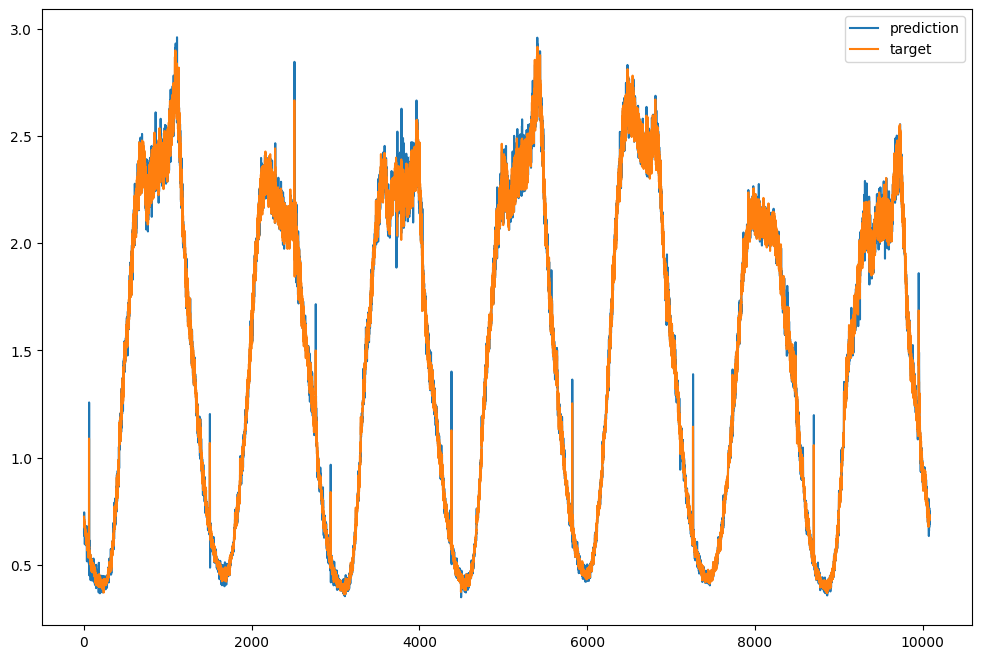

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.65104091, 0.7427001 , 0.74421859, ..., 0.76471293, 0.68688589,
       0.7478444 ])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.72416 ],
       [0.718512],
       [0.69116 ],
       ...,
       [0.736008],
       [0.705272],
       [0.728872]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 1.9730566069483757 %
RMSE 0.04376114532351494
MAPE 1.9846847280859947 %


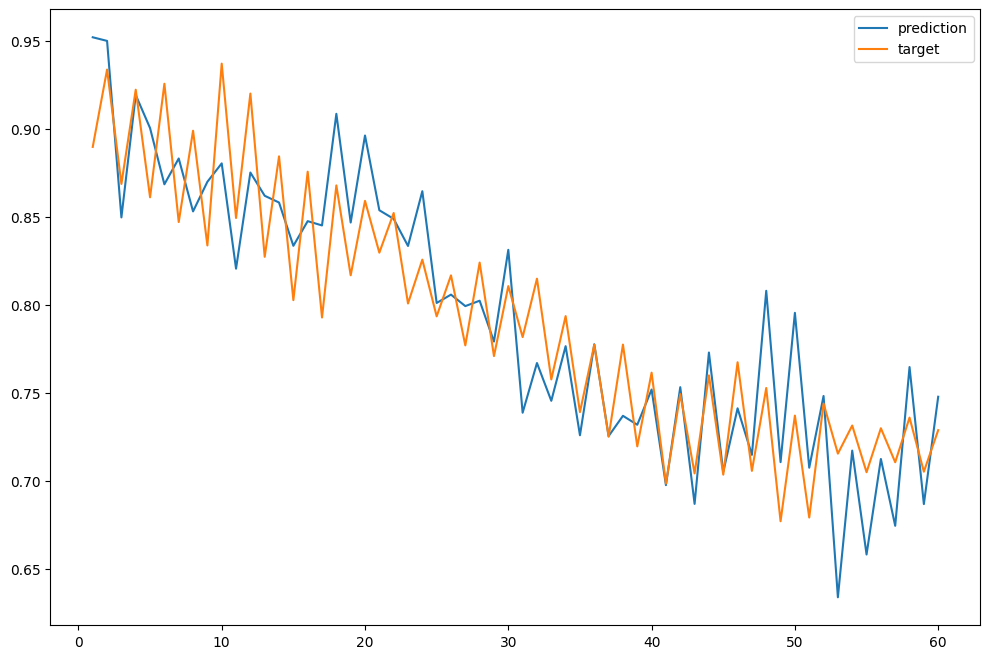

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

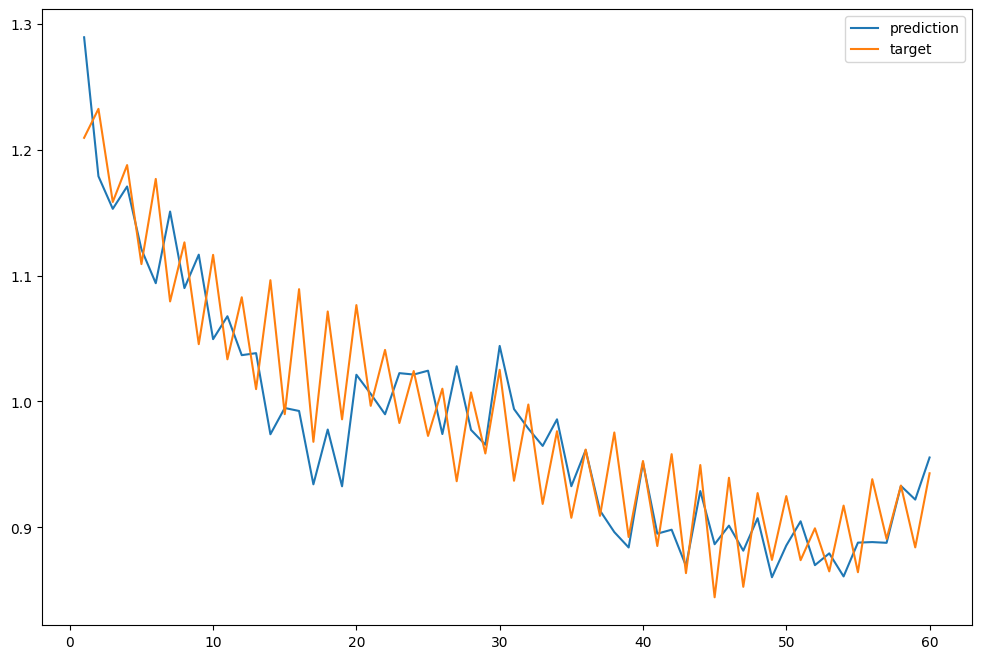

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

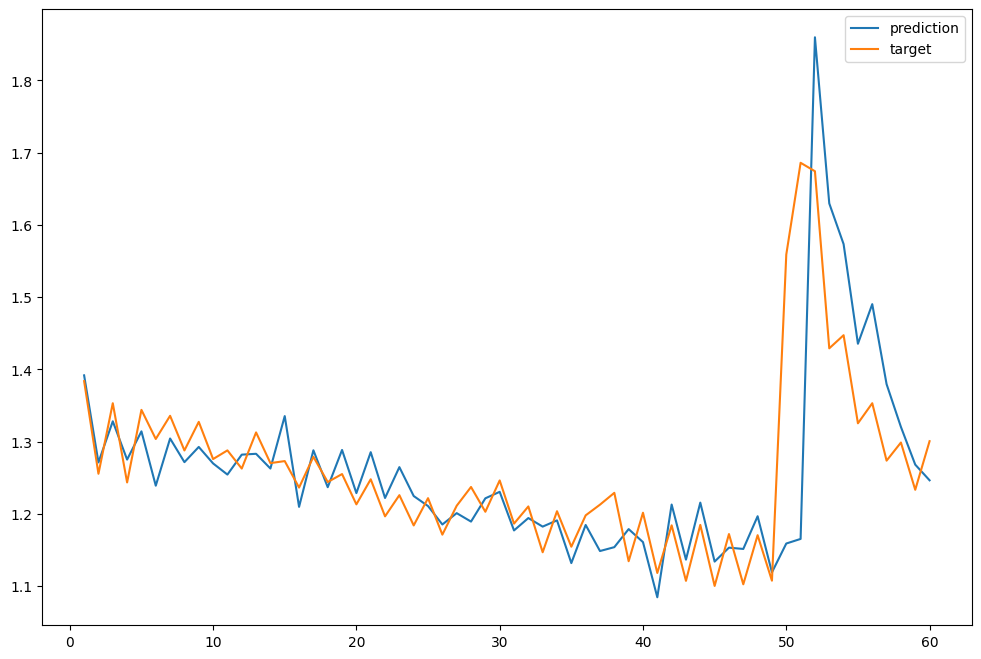

In [27]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-180:-120],label='prediction')
axes.plot(np.arange(1,61),target[-180:-120],label='target')
axes.legend()

In [28]:
len(time_list)

10080

In [29]:
np.mean(time_list) 

0.32364561555404514